# Импорт необходимых библиотек

In [102]:
# Импортируем необходимые библиотеки
import torch  # Для использования GPU (если доступен) и работы с тензорами
import numpy as np  # Для работы с массивами и математическими операциями
import matplotlib.pyplot as plt  # Для построения графиков
import tkinter as tk  # Для создания графического интерфейса
from tkinter import messagebox  # Для отображения диалоговых окон в графическом интерфейсе
import gymnasium as gym  # Для создания и использования среды OpenAI Gym
from gymnasium import spaces  # Для создания пространств действий и наблюдений
from stable_baselines3 import PPO  # Для использования алгоритма Proximal Policy Optimization (PPO)
from stable_baselines3.common.vec_env import DummyVecEnv  # Для создания векторизированной среды



# Настройка среды

In [103]:
class TicTacToeEnv(gym.Env):
    def __init__(self, size):
        self.size = size  # Размер поля (например, 3 для поля 3x3)
        self.board = np.zeros((self.size, self.size), dtype=int)  # Создание пустого игрового поля
        self.current_player = 1  # Определение текущего игрока (1 - крестик, 2 - нолик)
        self.action_space = gym.spaces.Discrete(self.size * self.size)  # Пространство действий (количество клеток на поле)
        self.observation_space = gym.spaces.Box(low=0, high=2, shape=(self.size, self.size), dtype=int)  # Пространство наблюдений (игровое поле)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.board = np.zeros((self.size, self.size), dtype=int)  # Сбрасываем игровое поле
        self.current_player = 1  # Устанавливаем текущего игрока
        return self.board, {}  # Возвращаем начальное состояние поля и пустой словарь

    def step(self, action):
        row, col = divmod(action, self.size)  # Преобразование действия в координаты клетки
        if self.board[row, col] != 0:
            # Если клетка занята, возвращаем текущее состояние без изменений
            return self.board, 0, False, False, {}

        self.board[row, col] = self.current_player  # Установка хода текущего игрока на поле
        reward = 0  # Начальная награда
        terminated = False  # Игра продолжается

        if self.check_winner(self.current_player):
            # Если текущий игрок выиграл
            reward = 10
            terminated = True
        elif len(self.available_actions()) == 0:
            # Если все клетки заняты и ничья
            reward = 2
            terminated = True
        else:
            if self.check_block_opponent():
                # Награда за блокировку хода противника
                reward += 5

            self.current_player = 3 - self.current_player  # Смена текущего игрока (1 -> 2 или 2 -> 1)

            if self.check_missed_block():
                # Наказание за пропущенную блокировку
                reward -= 5

        return self.board, reward, terminated, False, {}  # Возвращаем состояние, награду, флаг завершения и пустой словарь

    def available_actions(self):
        return [(i, j) for i in range(self.size) for j in range(self.size) if self.board[i, j] == 0]  # Возвращает список координат доступных клеток

    def check_winner(self, player):
        for i in range(self.size):
            # Проверка строк и столбцов на наличие выигрышной линии
            if np.all(self.board[i, :] == player) or np.all(self.board[:, i] == player):
                return True
        # Проверка диагоналей на наличие выигрышной линии
        if np.all(np.diag(self.board) == player) or np.all(np.diag(np.fliplr(self.board)) == player):
            return True
        return False  # Если выигрышных линий нет

    def check_block_opponent(self):
        opponent = 3 - self.current_player  # Определение противника
        for i in range(self.size):
            for j in range(self.size):
                if self.board[i, j] == 0:  # Если клетка пустая
                    self.board[i, j] = opponent
                    if self.check_winner(opponent):  # Проверяем, выиграет ли противник, если поставить сюда
                        self.board[i, j] = 0
                        return True  # Блокировка возможна
                    self.board[i, j] = 0
        return False  # Блокировка невозможна

    def check_missed_block(self):
        opponent = 3 - self.current_player  # Определение противника
        for i in range(self.size):
            for j in range(self.size):
                if self.board[i, j] == 0:  # Если клетка пустая
                    self.board[i, j] = opponent
                    if self.check_winner(opponent):  # Проверяем, выиграет ли противник, если поставить сюда
                        self.board[i, j] = 0
                        return True  # Пропущенная блокировка
                    self.board[i, j] = 0
        return False  # Блокировка не пропущена




# Функция тренировки агента и построение сглаженной кривой обучения

In [104]:
def train_agents(size, episodes):
    # Функция для обучения агентов игры "Крестики-нолики" с заданным размером поля и количеством эпизодов
    env = DummyVecEnv([lambda: TicTacToeEnv(size)])  # Создаем векторизированную среду для обучения агентов

    # Инициализация первого агента с использованием алгоритма Proximal Policy Optimization (PPO)
    # Используем GPU (если доступен) для ускорения обучения
    agent1 = PPO("MlpPolicy", env, verbose=1, device="cuda" if torch.cuda.is_available() else "cpu")
    # Инициализация второго агента аналогично первому
    agent2 = PPO("MlpPolicy", env, verbose=1, device="cuda" if torch.cuda.is_available() else "cpu")
    
    # Списки для сохранения истории побед каждого агента
    win_history_agent1 = []
    win_history_agent2 = []

    # Основной цикл обучения
    for episode in range(1, episodes + 1):
        obs = env.reset()  # Сбрасываем среду и получаем начальное наблюдение
        done = [False]  # Флаг завершения эпизода

        # Цикл выполнения шагов в эпизоде
        while not all(done):
            action1, _ = agent1.predict(obs)  # Первый агент предсказывает действие на основе текущего наблюдения
            obs, reward1, done, info = env.step(action1)  # Выполняем действие и получаем новые наблюдения и награды
            if all(done):  # Если эпизод завершен, сохраняем результат и выходим из цикла
                win_history_agent1.append(reward1[0])
                win_history_agent2.append(-reward1[0])
                break

            action2, _ = agent2.predict(obs)  # Второй агент предсказывает действие на основе текущего наблюдения
            obs, reward2, done, info = env.step(action2)  # Выполняем действие и получаем новые наблюдения и награды
            if all(done):  # Если эпизод завершен, сохраняем результат
                win_history_agent2.append(reward2[0])
                win_history_agent1.append(-reward2[0])

        # Каждые 1000 эпизодов выводим прогресс обучения
        if episode % 1000 == 0:
            print(f'Эпизод {episode}/{episodes} завершен.')

    # Сохраняем обученные модели агентов
    agent1.save("agent1_ppo_3x3")
    agent2.save("agent2_ppo_3x3")

    # Возвращаем обученных агентов и историю их побед
    return agent1, agent2, win_history_agent1, win_history_agent2



# Построение кривой обучения

In [105]:
def plot_learning_curve(win_history, agent_name="Агент"):
    # Определяем размер окна для скользящего среднего
    window_size = 100
    
    if len(win_history) < window_size:
        print("Недостаточно данных для вычисления скользящего среднего")
        return
    
    # Вычисляем скользящее среднее значений в истории побед
    smoothed_win_history = np.convolve(win_history, np.ones(window_size) / window_size, mode='valid')
    
    # Строим график кривой обучения
    plt.plot(smoothed_win_history, label=f"{agent_name}: Скользящее среднее выигрышей")
    
    # Устанавливаем метку по оси X
    plt.xlabel('Эпизоды')
    # Устанавливаем метку по оси Y
    plt.ylabel('Средний результат (10 - победа, 2 - ничья, 0 - поражение)')
    
    # Устанавливаем заголовок графика
    plt.title(f'Кривая обучения для {agent_name}')
    
    # Добавляем легенду на график
    plt.legend()
    
    # Отображаем график
    plt.show()


# Инициализация агента и обучение на поле размером 3х3

Using cuda device
Using cuda device
Эпизод 1000/10000 завершен.
Эпизод 2000/10000 завершен.
Эпизод 3000/10000 завершен.
Эпизод 4000/10000 завершен.
Эпизод 5000/10000 завершен.
Эпизод 6000/10000 завершен.
Эпизод 7000/10000 завершен.
Эпизод 8000/10000 завершен.
Эпизод 9000/10000 завершен.
Эпизод 10000/10000 завершен.
Отображение графика обучения агента 1


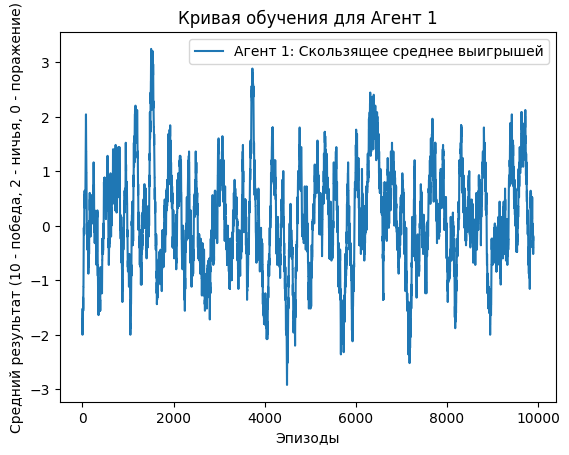

Отображение графика обучения агента 2


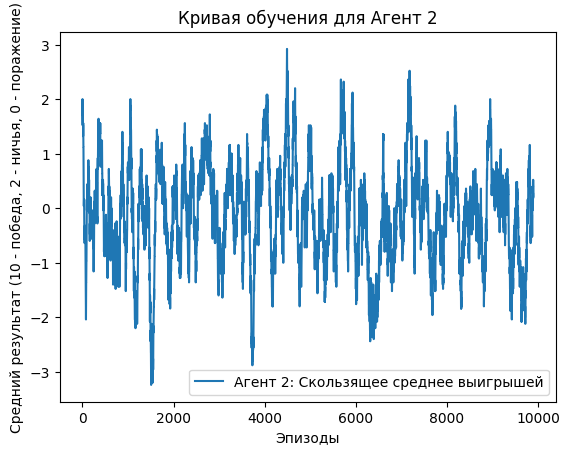

In [106]:
def main():
    # Главная функция программы, запускающая обучение агентов и отображение графиков

    size = 3  # Устанавливаем размер игрового поля (например, 3 для поля 3x3)
    
    episodes = 10000  # Устанавливаем количество эпизодов для обучения агентов
    
    # Обучаем агентов и получаем историю побед для каждого из них
    agent1, agent2, win_history_agent1, win_history_agent2 = train_agents(size=size, episodes=episodes)
    
    if win_history_agent1:
        # Если у первого агента есть история побед, отображаем график его обучения
        print("Отображение графика обучения агента 1")
        plot_learning_curve(win_history_agent1, "Агент 1")

    if win_history_agent2:
        # Если у второго агента есть история побед, отображаем график его обучения
        print("Отображение графика обучения агента 2")
        plot_learning_curve(win_history_agent2, "Агент 2")

if __name__ == "__main__":
    # Запускаем основную функцию, если скрипт выполняется напрямую
    main()


# По графикам можно сделать вывод что оба агента обучились игре (если смотреть на них то они противоположны друг другу, что логично)

# Протестируем агента, чтобы убедиться что он обучился игре (для тестирования возьмём например агента 1)

In [107]:
def plot_test_results(results, title):
    episodes = range(1, len(results) + 1)  # Создание диапазона эпизодов, равного количеству результатов
    plt.plot(episodes, results, marker='o', linestyle='-', color='b')  # Построение графика с отметками в виде кругов и синей линией
    plt.xlabel('Эпизоды')  # Установка метки оси X
    plt.ylabel('Результат')  # Установка метки оси Y
    plt.title(title)  # Установка заголовка графика
    plt.show()  # Отображение графика


1. Среда со случайным агентом

In [108]:
class RandomAgent:
    def __init__(self, action_space):
        self.action_space = action_space  # Инициализация пространства действий

    def predict(self, observation):
        return self.action_space.sample(), None  # Выбор случайного действия и возврат значения None для совместимости

# Тестирование обученного агента против случайного агента
def test_against_random_agent(trained_agent, size=3, episodes=10):
    env = TicTacToeEnv(size)  # Создание среды с указанным размером поля
    random_agent = RandomAgent(env.action_space)  # Создание случайного агента
    results = []

    for episode in range(episodes):
        state, _ = env.reset()  # Сброс среды и извлечение начального состояния
        done = False
        print(f"\nЭпизод {episode + 1}")  # Вывод номера текущего эпизода

        while not done:
            action, _ = trained_agent.predict(state)  # Предсказание действия обученного агента
            state, reward, done, _, _ = env.step(action)  # Выполнение действия и обновление состояния среды
            if done:
                break  # Если игра завершена, прерываем цикл

            action, _ = random_agent.predict(state)  # Предсказание действия случайного агента
            state, reward, done, _, _ = env.step(action)  # Выполнение действия и обновление состояния среды

        results.append(reward)  # Добавление награды текущего эпизода в список результатов
        print(f"Результат эпизода: {reward}")  # Вывод результата текущего эпизода

    plot_test_results(results, "Результаты против случайного агента")  # Построение графика результатов



Эпизод 1
Результат эпизода: 10

Эпизод 2
Результат эпизода: 2

Эпизод 3
Результат эпизода: 10

Эпизод 4
Результат эпизода: 10

Эпизод 5
Результат эпизода: 10

Эпизод 6
Результат эпизода: 10

Эпизод 7
Результат эпизода: 10

Эпизод 8
Результат эпизода: 10

Эпизод 9
Результат эпизода: 10

Эпизод 10
Результат эпизода: 10


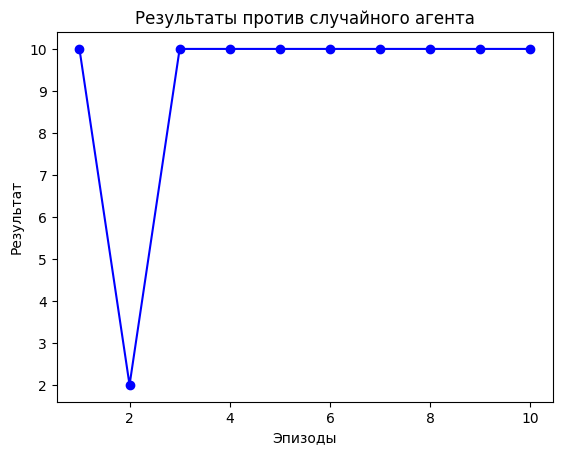

In [111]:
# Загрузка обученной модели агента
agent1 = PPO.load("agent1_ppo_3x3")

# Тестирование против случайного агента
test_against_random_agent(agent1)


# При игре с со случайным агентом наш агент не проиграл ни разу

2. Среда с измененными начальными условиями (ставим первым ходом крестик в центр, при этом агент играет за нолик)

In [112]:
class TicTacToeEnvModified(TicTacToeEnv):
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)  # Вызов метода reset родительского класса для сброса состояния
        self.board[self.size // 2, self.size // 2] = 1  # Устанавливаем крестик в центре доски
        self.current_player = 2  # Агент начинает игру, играя за нолик
        return self.board, {}  # Возвращаем начальное состояние доски и пустой словарь


In [113]:
def test_modified_conditions(trained_agent, size=3, episodes=10):
    env = TicTacToeEnvModified(size)  # Создание среды с измененными начальными условиями
    results = []

    for episode in range(episodes):
        state, _ = env.reset()  # Сброс среды и извлечение начального состояния
        done = False
        print(f"\nЭпизод {episode + 1}")  # Вывод номера текущего эпизода

        while not done:
            action, _ = trained_agent.predict(state)  # Предсказание действия обученного агента
            state, reward, done, _, _ = env.step(action)  # Выполнение действия и обновление состояния среды

        results.append(reward)  # Добавление награды текущего эпизода в список результатов
        print(f"Результат эпизода: {reward}")  # Вывод результата текущего эпизода

    plot_test_results(results, "Результаты с измененными начальными условиями")  # Построение графика результатов



Эпизод 1
Результат эпизода: 10

Эпизод 2
Результат эпизода: 10

Эпизод 3
Результат эпизода: 10

Эпизод 4
Результат эпизода: 10

Эпизод 5
Результат эпизода: 10

Эпизод 6
Результат эпизода: 10

Эпизод 7
Результат эпизода: 10

Эпизод 8
Результат эпизода: 10

Эпизод 9
Результат эпизода: 10

Эпизод 10
Результат эпизода: 10


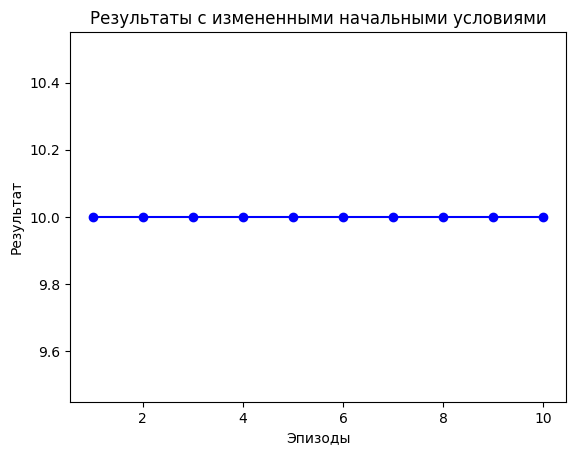

In [116]:
# Загрузка обученной модели агента
agent1 = PPO.load("agent1_ppo_3x3")

# Тестирование в среде с измененными начальными условиями
test_modified_conditions(agent1)


# При игре с изменёнными начальными условиями агент не проиграл ни разу

# Запуск игры на поле произвольного размера

In [118]:
class TicTacToeGUI:
    def __init__(self, root, size, agent1, agent2=None):
        # Инициализация графического интерфейса для игры "Крестики-нолики"
        self.root = root  # Корневой элемент графического интерфейса
        self.size = size  # Размер игрового поля
        self.agent1 = agent1  # Агент 1, который будет играть против человека или другого агента
        self.agent2 = agent2  # (опционально) Агент 2, если требуется игра между двумя агентами
        self.game = TicTacToeEnv(size)  # Создаем экземпляр среды игры "Крестики-нолики"
        self.game.reset()  # Сбрасываем игру до начального состояния

        # Создаем кнопки для игрового поля
        self.buttons = [[None for _ in range(size)] for _ in range(size)]
        self.create_board()  # Вызываем функцию для создания игрового поля
        self.current_agent = agent1  # Устанавливаем текущего агента (по умолчанию агент 1)
        self.player_turn = True  # Флаг, указывающий, что сейчас ходит человек

    def create_board(self):
        # Функция для создания игрового поля (кнопки) в графическом интерфейсе
        for i in range(self.size):
            for j in range(self.size):
                button = tk.Button(self.root, text=" ", font='Arial 20', width=5, height=2,
                                   command=lambda row=i, col=j: self.human_move(row, col))
                button.grid(row=i, column=j)  # Размещаем кнопку в сетке
                self.buttons[i][j] = button  # Сохраняем ссылку на кнопку

    def human_move(self, row, col):
        # Обработка хода человека
        if self.game.board[row, col] == 0 and self.player_turn:
            print(f"Player moves to: ({row}, {col})")
            state, reward, done, truncated, info = self.game.step((row * self.size) + col)
            self.update_board()  # Обновляем отображение игрового поля
            print(f"step returns: {state}, {reward}, {done}, {truncated}, {info}")
            if done:
                if self.check_game_over():  # Проверяем, завершена ли игра
                    return
            self.player_turn = False  # Передаем ход агенту
            self.agent_move()

    def agent_move(self):
        # Обработка хода агента
        if self.current_agent and not self.player_turn:
            print("Agent's move")
            state = self.game.board.reshape((1, self.size, self.size))  # Преобразуем в нужную форму
            
            valid_move = False
            while not valid_move:
                # Обрезаем или масштабируем доску до размера 3x3, чтобы соответствовать модели
                resized_state = state[:, :3, :3]  # Временно обрезаем до 3x3 для предсказания
                action, _ = self.current_agent.predict(resized_state)  # Агент предсказывает действие
                row, col = divmod(action, self.size)
                
                if (row, col) in self.game.available_actions():  # Проверяем валидность хода
                    valid_move = True
                    print(f"Agent moves to: ({row}, {col})")
                    state, reward, done, truncated, info = self.game.step(action)
                    self.update_board()  # Обновляем отображение игрового поля
                    print(f"step returns: {state}, {reward}, {done}, {truncated}, {info}")
                    if done:
                        if self.check_game_over():  # Проверяем, завершена ли игра
                            return
                    self.player_turn = True  # Передаем ход человеку
                else:
                    print(f"Invalid move by agent: ({row}, {col}), retrying...")

    def update_board(self):
        # Обновление отображения игрового поля в графическом интерфейсе
        for i in range(self.size):
            for j in range(self.size):
                if self.game.board[i, j] == 1:
                    self.buttons[i][j].config(text='X')  # Отображаем крестики
                elif self.game.board[i, j] == 2:
                    self.buttons[i][j].config(text='O')  # Отображаем нолики
                else:
                    self.buttons[i][j].config(text=' ')  # Очищаем клетку

    def check_game_over(self):
        # Проверка, завершена ли игра, и отображение сообщения
        if self.game.check_winner(1):
            print("Player 1 wins")
            tk.messagebox.showinfo("Game Over", "Поздравляем! Игрок 1 (X) победил!")
            self.reset_game()  # Сбрасываем игру
            return True
        elif self.game.check_winner(2):
            print("Agent wins")
            tk.messagebox.showinfo("Game Over", "Агент (O) победил!")
            self.reset_game()  # Сбрасываем игру
            return True
        elif len(self.game.available_actions()) == 0:
            print("Draw")
            tk.messagebox.showinfo("Game Over", "Ничья!")
            self.reset_game()  # Сбрасываем игру
            return True
        return False

    def reset_game(self):
        # Сброс состояния игры и обновление игрового поля
        print("Resetting game")
        self.game.reset()
        self.update_board()

def start_game(agent1):
    # Функция для запуска графического интерфейса и начала игры
    size = int(input("Введите размер поля для игры (например, 3 для 3x3): "))
    root = tk.Tk()  # Создаем корневой элемент графического интерфейса
    root.title("Крестики-Нолики")  # Устанавливаем заголовок окна
    app = TicTacToeGUI(root, size, agent1)  # Создаем экземпляр класса TicTacToeGUI
    print("Запуск графического интерфейса")
    root.mainloop()  # Запускаем основной цикл графического интерфейса

# Загрузка обученной модели агента 1
agent1 = PPO.load("agent1_ppo_3x3.zip")

# Запуск игры
start_game(agent1)




Запуск графического интерфейса
Player moves to: (1, 1)
step returns: [[0 0 0]
 [0 1 0]
 [0 0 0]], 0, False, False, {}
Agent's move
Agent moves to: ([2], [2])
step returns: [[0 0 0]
 [0 1 0]
 [0 0 2]], 0, False, False, {}
Player moves to: (0, 2)
step returns: [[0 0 1]
 [0 1 0]
 [0 0 2]], -5, False, False, {}
Agent's move
Agent moves to: ([0], [0])
step returns: [[2 0 1]
 [0 1 0]
 [0 0 2]], 5, False, False, {}
Player moves to: (1, 2)
step returns: [[2 0 1]
 [0 1 1]
 [0 0 2]], -5, False, False, {}
Agent's move
Invalid move by agent: ([0], [2]), retrying...
Agent moves to: ([1], [0])
step returns: [[2 0 1]
 [2 1 1]
 [0 0 2]], 0, False, False, {}
Player moves to: (2, 0)
step returns: [[2 0 1]
 [2 1 1]
 [1 0 2]], 10, True, False, {}
Player 1 wins
Resetting game
